In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-08-08 13:58:38.276465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754661518.438156      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754661518.487556      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load and preprocess the dataset
df = pd.read_csv('/kaggle/input/household-power-consumption/household_power_consumption.txt',
                 sep=';',
                 na_values='?',
                 low_memory=False)


In [4]:
# Combine date and time into a timestamp
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df[['timestamp', 'Global_active_power']]
df = df.rename(columns={'Global_active_power': 'consumption'})
df = df.dropna()

df = df.set_index('timestamp')
df['consumption'] = df['consumption'].astype(float)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['consumption']])

In [6]:
# Create sequences for multi-step forecasting
def create_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(input_len, len(data) - output_len + 1):
        X.append(data[i - input_len:i, 0])
        y.append(data[i:i + output_len, 0])
    return np.array(X), np.array(y)

# Sequence parameters
input_sequence = 24    # past 24 hours
output_sequence = 3    # predict next 3 hours
X, y = create_sequences(scaled_data, input_sequence, output_sequence)

# Reshape input for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train/val/test
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

I0000 00:00:1754661740.440303      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754661740.440946      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1754661747.042282     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


44828/44828 ━━━━━━━━━━━━━━━━━━━━ 459s 10ms/step - loss: 0.0014 - mae: 0.0185 - val_loss: 9.5479e-04 - val_mae: 0.0136
Epoch 2/20
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 458s 10ms/step - loss: 0.0012 - mae: 0.0165 - val_loss: 9.9015e-04 - val_mae: 0.0143
Epoch 3/20
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 457s 10ms/step - loss: 0.0011 - mae: 0.0159 - val_loss: 9.2665e-04 - val_mae: 0.0127
Epoch 4/20
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 459s 10ms/step - loss: 0.0011 - mae: 0.0156 - val_loss: 9.0914e-04 - val_mae: 0.0127
Epoch 5/20
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 458s 10ms/step - loss: 0.0011 - mae: 0.0152 - val_loss: 9.4484e-04 - val_mae: 0.0150
Epoch 6/20
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 462s 10ms/step - loss: 0.0011 - mae: 0.0150 - val_loss: 8.7757e-04 - val_mae: 0.0136
Epoch 7/20
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 462s 10ms/step - loss: 0.0011 - mae: 0.0148 - val_loss: 8.9492e-04 - val_mae: 0.0135
Epoch 8/20
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 464s 10ms/step - loss: 0.0010 - mae: 0.0147 - val_loss: 8.7440e-

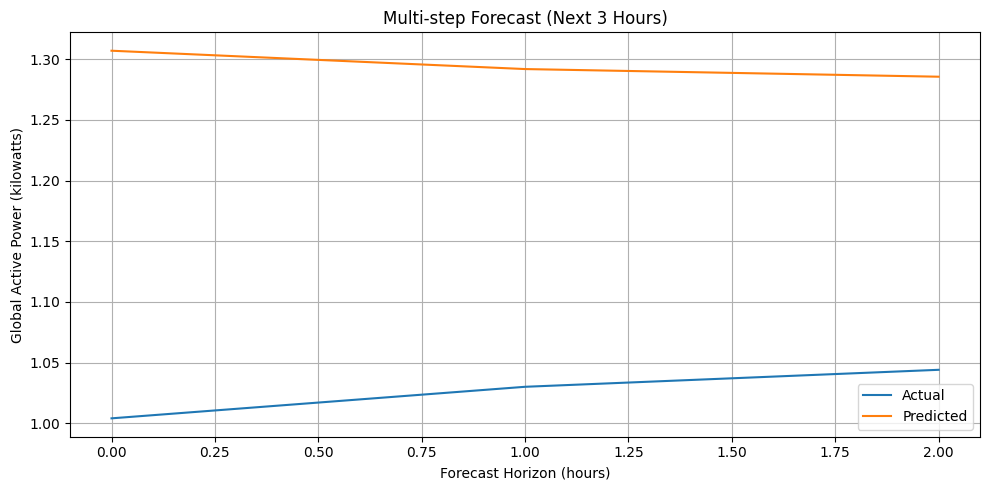

In [7]:
# Build enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X.shape[1], 1)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(output_sequence)  # Output is a vector of next 3 values
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Load best model weights (optional if you want the best result)
model.load_weights('best_model.h5')

# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
real = scaler.inverse_transform(y_test)

# Plot predictions vs actual for one example (e.g., first test sample)
plt.figure(figsize=(10, 5))
plt.plot(real[0], label='Actual')
plt.plot(predictions[0], label='Predicted')
plt.title('Multi-step Forecast (Next 3 Hours)')
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
